In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seawater
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
fName = "/Users/hector/Desktop/V000015.txt"
nSkip = 9

df = pd.read_csv(fName, 
                 skiprows=nSkip,
                 delimiter="\t",
                 names=["Pressure", "Temperature", "Conductivity"],
                )
metadata = {}
with open(fName) as fd:
    for i in range(nSkip):
        tmp = next(fd).split(": ")
        metadata[tmp[0]] = tmp[1]
metadata

{'Now': '12/09/2023 09:16:56\n',
 'Battery Level': '1.4V\n',
 '\x00MiniCTD': 'S/N 58934\n',
 'Site info': '2023_AMARRADEROBOYANORTE_12SEP\n',
 'Calibrated': '22/02/2017\n',
 'Latitude': '21.361392\n',
 'Mode': 'M1\n',
 'Tare': '10.1028\n',
 'Pressure units': 'dBar\n'}

In [188]:
# Calculate time
time = pd.date_range(start=metadata['Now'], periods=len(df), freq="200ms")
df['time'] = time

# Conductivity of seawater at 35 C 
C35 = 4.2914 #Siemens/meter
C35 = 42.914 #mS/cm
seawater.salrt(35)

# Calculate conductivity ratio, salinity and density
df['Cond_Ratio'] = df.Conductivity/C35
df['Salinity'] = seawater.eos80.salt(df['Cond_Ratio'], df['Temperature'], df['Pressure'])
df['Density'] = seawater.eos80.dens(df['Salinity'], df['Temperature'], df['Pressure'])

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/seawater/library.py:363: RuntimeWarning: invalid value encountered in sqrt
  Rtx = (rt) ** 0.5


In [191]:
def cluster_throw(df):

    ind = df.index[df.Salinity>2]
    output = np.ones_like(df.Salinity)*-1
    c = 0
    for i,j in zip(ind[0:-1], ind[1:]):
            if j-i <=1:
                output[i] = c
                output[j] = c
            else:
                output[i] = c
                c += 1
                output[j] = c
                
    return output

In [192]:
df['Lances'] = cluster_throw(df)

In [193]:
df

,Pressure,Temperature,Conductivity,time,Cond_Ratio,Salinity,Density,Lances
0,-0.000,29.483,NaN,2023-12-09 09:16:56.000,-0.000396,NaN,NaN,-1.0
1,-0.001,29.489,NaN,2023-12-09 09:16:56.200,-0.000373,NaN,NaN,-1.0
2,-0.002,29.499,NaN,2023-12-09 09:16:56.400,-0.000373,NaN,NaN,-1.0
3,-0.002,29.504,NaN,2023-12-09 09:16:56.600,-0.000396,NaN,NaN,-1.0
4,0.001,29.512,NaN,2023-12-09 09:16:56.800,-0.000373,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...
12398,-0.018,30.589,NaN,2023-12-09 09:58:15.600,-0.000396,NaN,NaN,-1.0
12399,-0.021,30.593,NaN,2023-12-09 09:58:15.800,-0.000396,NaN,NaN,-1.0
12400,-0.019,30.592,NaN,2023-12-09 09:58:16.000,-0.000396,NaN,NaN,-1.0
12401,-0.020,30.592,NaN,2023-12-09 09:58:16.200,-0.000396,NaN,NaN,-1.0


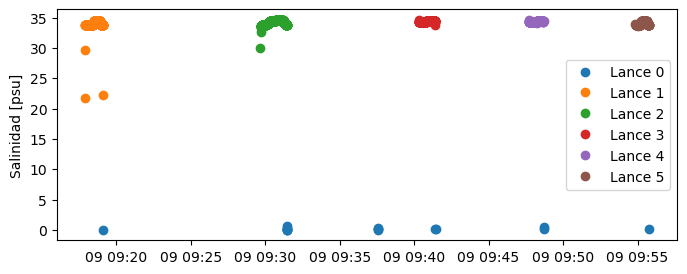

In [183]:
fig,ax = plt.subplots(figsize=(8,3))

for i,g in enumerate(df.Lances.unique()):
    tmp = df[df.Lances==g]
    ax.plot(tmp.time, tmp.Salinity, marker="o", lw=0, color="C"+str(i), label="Lance {}".format(i))
ax.legend()
_ = ax.set_ylabel("Salinidad [psu]")


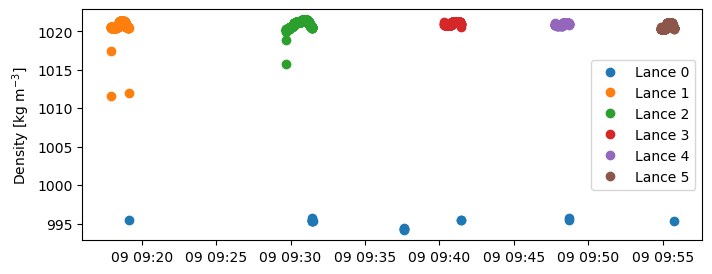

In [195]:
fig,ax = plt.subplots(figsize=(8,3))

for i,g in enumerate(df.Lances.unique()):
    tmp = df[df.Lances==g]
    ax.plot(tmp.time, tmp.Density, marker="o", lw=0, color="C"+str(i), label="Lance {}".format(i))
ax.legend()
_ = ax.set_ylabel(r"Density [kg m$^{-3}$]")